In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SALib
from SALib.plotting import bar
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)
from pandas.core.common import flatten
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from settings import *

## Plot Sobol' SA with dummy parameter included

In [3]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
# plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

NameError: name 'pd' is not defined

## Plot the adaptive evaluation

In [2]:
from utils.plots import plot_metric_sampling
from settings import *

In [6]:
# # conver the standard error into standard deviation
# filename = ['fix_6', 'fix_9', 'fix_10', 'fix_13', 'fix_17'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
# fpath = '../output/adaptive_replicates/morris/bootstrap_mc/'
# for fr in os.listdir(fpath):
#     r = int(fr[1:])
#     for fn in filename:
#         df = pd.read_csv(f'{fpath}{fr}/{fn}/mean_estimation.csv', index_col = 'Unnamed: 0')#.iloc[0:50]
#         cols = df.columns
#         for col in cols[3:]:
#             df.loc[:, col] = df.loc[:, col] * np.sqrt(r)
#         df.to_csv(f'{fpath}{fr}/{fn}/mean_std.csv')

In [33]:
# # conver the standard error into standard deviation
# filename = ['fix_6', 'fix_9', 'fix_10', 'fix_12', 'fix_13', 'fix_17'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
# fpath = '../output/adaptive_replicates/morris/bootstrap_mc/'
# for fn in filename:
#     df = pd.read_csv(f'{fpath}{fn}/replicate0.csv', index_col = 'Unnamed: 0')#.iloc[0:50]
#     cols = df.columns
#     for i in range(3):
#         df.loc[:, cols[i+3]] = df.loc[:, cols[i]]  - 1.96 * (df.loc[:, cols[i]] - df.loc[:, cols[i + 3]])
#         df.loc[:, cols[i+6]] = df.loc[:, cols[i]] + 1.96 * (df.loc[:, cols[i+6]] - df.loc[:, cols[i]])
#     df.to_csv(f'{fpath}{fn}/mean_ci.csv')

In [83]:
df = {}
filename = ['fix_9'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/adaptive_replicates/morris/bootstrap_mc/' #vertical/r20/'bootstrap_mc/
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_ci.csv', index_col = 'Unnamed: 0')#.iloc[0:20]
    df[fn].index = df[fn].index.astype('int')
    df[fn].index = (df[fn].index + 1) * 100

In [84]:
# shared properties
sns.set_style('whitegrid')
plt.rcParams['legend.title_fontsize'] = 14
colors = ['lightgreen', 'orange', 'cornflowerblue', 'yellow', 'gray']
plot_kwagrs = {'kind':'line', 'marker':'o', 'linewidth':1, 'style':'-', 'ms':4, 'alpha':1.0, 'logy':False}
xlab = 'Number of sample size'
legds = ['RMAE', 'RV', 'r']
fs = 15; 
lgd = [fn.split('_')[1] for fn in filename]

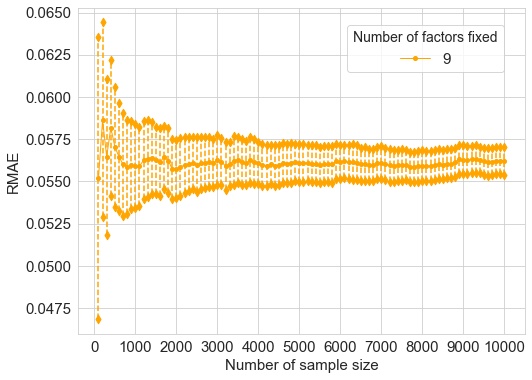

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
metric = [fn for fn in METRIC_NAME if not '_' in fn ][0]
ylab = legds[0]; 
xtick_locator = 1000; legd_loc = 'upper right'
bbox_to_anchor = (0.97, 0.97)
k = 1
mean_lab = f'{metric}'; 
for fn in filename:
    df_plot = df[fn]
    # bbox_to_anchor=(0.65, 0.15)
    ax = plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, 
                              fs, colors[k], lgd=lgd, ax=axes,legd_bbox=bbox_to_anchor, **plot_kwagrs)
    k += 1
plt.savefig(f'../output/adaptive_replicates/figure/boots_mc_{metric}_figure4.png', format = 'png', dpi = 400)

In [91]:
# plot adaptive replicates
from settings import *
fpath = '../output/adaptive_replicates/morris/vertical/'
filename = os.listdir(fpath)
df_collect = {}
fix_lists = ['fix_6', 'fix_9', 'fix_10']
for ii in fix_lists:
    df = {}
    for fn in filename:
#         print(f'{fpath}{fn}/{ii}/mean_std.csv')
        df_temp = pd.read_csv(f'{fpath}{fn}/{ii}/mean_std.csv', index_col = 'Unnamed: 0').iloc[1]
        df[50 * int(fn[1:])] = df_temp
    df = pd.DataFrame.from_dict(df).T
    df.sort_index(inplace=True)
    df_collect[ii] = df#.iloc[0:11]

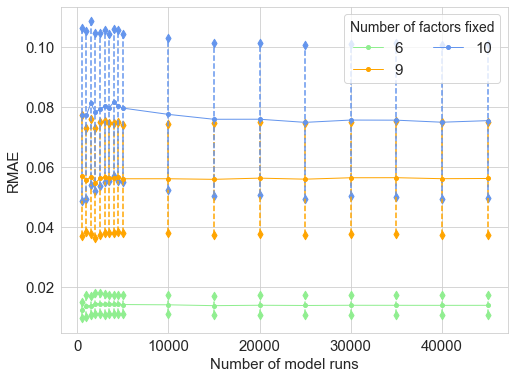

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
k = 0
metric = [fn for fn in METRIC_NAME if not '_' in fn ][0]
ylab = legds[0];
for ii in fix_lists:
    df_plot = df_collect[ii]
    mean_lab = f'{metric}_mean';
    xtick_locator = 10000; legd_loc = 'lower right' #'upper right'bbox_to_anchor=(0.65, 0.15)
    ax = plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, fs, colors[k], 
                              lgd=lgd, ax=axes, legd_loc = 'upper right', **plot_kwagrs)
    k += 1
    
#     plot_metric_sampling(df_plot, filename, metric, mean_lab, xlab, ylab, xtick_locator, 
#                               fs, colors[k], lgd=lgd, ax=axes,legd_bbox=bbox_to_anchor, **plot_kwagrs)
# plt.savefig(f'../output/adaptive_replicates/figure/adaptive_replicate50_{metric}.png', format = 'png', dpi = 400)

## Plot Figure 7 

In [93]:
from settings import *
df = {}
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_12', 'fix_17']
fpath = '../output/adaptive_replicates/morris/bootstrap_mc/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_ci.csv', index_col = 'Unnamed: 0').iloc[9]
df_metric = pd.DataFrame.from_dict(df, orient = 'index')
new_index = [ind.split('_')[1] for ind in list(df_metric.index)]
df_metric.index = new_index
# df_metric

In [94]:
# obtain relative bias    
cols = df_metric.columns
df_metric.fillna(value=0.0, inplace=True)
# drop the first row due to RMAE > 0.40
cols = df_metric.columns
# yerror = [df_metric.loc[:, col].values for col in cols[-3:]]
yerror = df_metric.loc[:, cols[-3:]].values.T - df_metric.loc[:, cols[0:3]].values.T
df_metric['ppmc'] = df_metric['ppmc'].apply(lambda x: 1 - x)
df_metric['var'] = df_metric['var'].apply(lambda x: np.abs(1 - x))

x = df_metric.index
# df_metric.index = ([str(21 - i) for i in x])


In [95]:
# import the analytic variance 
fvariance = np.loadtxt('../data/variance_frac.txt')
# total_variance = 2.755
index_fix = np.array([[20, 17, 19, 15, 16, 18], [14, 12, 13], 
                    [11], [9, 10], [8, 7, 6, 5, 4], [2, 3, 0, 1]])
variance_frac = fvariance[[len(list(flatten(index_fix[0:i+1])))-1 for i in range(index_fix.size-1)]] / 100
variance_frac = np.append(variance_frac, fvariance[-1])
variance_frac = variance_frac[[0, 1, 2, 3, 4]]

<Figure size 432x360 with 0 Axes>

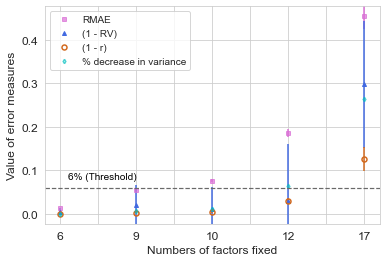

In [96]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 5))
# form x label
num_in_groups = []
conf_names = [col for col in METRIC_NAME if '_conf' in col]
colors = ['orchid', 'royalblue','chocolate']
ax = df_metric[cols[:3]].plot(kind='line', yerr=yerror, linestyle='', color=colors)

x = df_metric.index
x_ticklabels = ['{}{}{}{}'.format(i, ' (', x[i], ')') for i in range(len(x))]

ax.plot(x, df_metric[METRIC_NAME[0]], 's', color=colors[0], ms=4, alpha=0.7, label='RMAE')
ax.plot(x, df_metric[METRIC_NAME[1]], '^', color=colors[1], ms=4, label='RV')
ax.plot(x, df_metric[METRIC_NAME[2]], 'o', ms=5, markerfacecolor='none',label='PPMC',
        markeredgecolor=colors[2], markeredgewidth=1.5)
          
ax.plot(x, variance_frac, 'd', ms=3, markerfacecolor='none',label='First-order variance',
        markeredgecolor='c', markeredgewidth=1.5, alpha=0.7)            
                                                                  
ax.axhline(y=0.06, xmin=0, xmax=6, linestyle='--', linewidth=1.2, color='dimgrey')
ax.tick_params(axis='both', labelsize=12)

ax.set_xlabel('Numbers of factors fixed', fontsize=12)
ax.set_ylabel('Value of error measures', fontsize=12)
# ax.set_ylim(-0.03, 0.5)
# ax.set_xlim(0.85, 7.15)

ax.legend(['RMAE', '(1 - RV)', '(1 - r)', '% decrease in variance'], loc='upper left', fontsize=10)
ax.text(0.1, 0.08, '6% (Threshold)', fontsize=10, color='k')
plt.savefig('{}{}{}'.format('../output/adaptive_replicates/figure/', 'fig7_variance', '.png'), dpi=300, format='png')

## Figure 7

In [14]:
"""Create figure 7 for paper."""
from settings import *

# plot for figure type I
f_dir = ['../output/reuse_sample/morris/compare/'+'0.25/',
         '../output/reuse_sample/sobol/compare/'+'0.25/']
f_names = ['mae', 'mae_lower','mae_upper']
def f_read(filename):
    df = pd.read_csv(filename)
    df.drop(columns = 'Unnamed: 0', inplace=True)
    df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
    return df

<Figure size 720x432 with 0 Axes>

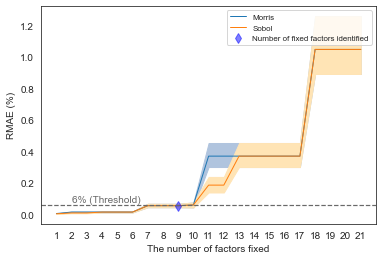

In [15]:
sample_size = ['result_80', 'result_800']
f_morris = f_read(f'{f_dir[0]}{f_names[0]}.csv')
mae_comp = pd.DataFrame(index=f_morris.index)
mae_comp['Morris'] = f_morris[sample_size[0]]
mae_comp['Sobol'] = f_read(f'{f_dir[1]}{f_names[0]}.csv').loc[:, sample_size[1]]
mae_comp['Morris_lower'] = f_read(f'{f_dir[0]}{f_names[1]}.csv').loc[:, sample_size[0]]
mae_comp['Morris_upper'] = f_read(f'{f_dir[0]}{f_names[2]}.csv').loc[:, sample_size[0]]
mae_comp['Sobol_lower'] = f_read(f'{f_dir[1]}{f_names[1]}.csv').loc[:, sample_size[1]]
mae_comp['Sobol_upper'] = f_read(f'{f_dir[1]}{f_names[2]}.csv').loc[:, sample_size[1]]

cols =  mae_comp.columns

fig = plt.figure(figsize=(10, 6))
sns.set_style('white')
palette = plt.get_cmap('Set1')
col_conf = [col for col in cols if '_conf' in col]
ax = mae_comp[cols[0:2]].plot(kind='line', linewidth=1)
ax.fill_between(mae_comp.index, mae_comp['Morris_lower'], 
                mae_comp['Morris_upper'],color='lightsteelblue', label=f'95% CIs for Morris')                
ax.fill_between(mae_comp.index, mae_comp['Sobol_lower'], 
                mae_comp['Sobol_upper'],color='moccasin', label=f'95% CIs for Sobol')

ax.plot(mae_comp['Sobol'][8:9], 'd', color='blue', alpha=0.5, ms=7,
        label='Number of fixed factors identified')
ax.axhline(y=0.06, xmin=0, xmax=21, linestyle='--', linewidth=1.2, color='dimgrey')

ax.set_xticks(range(len(mae_comp)))
ax.set_xticklabels(np.arange(1, 22));
ax.set_xlabel('The number of factors fixed', fontsize=10)
ax.set_ylabel('RMAE (%)', fontsize=10)
leg = ax.legend(['Morris', 'Sobol',
                 'Number of fixed factors identified',
                 ], #'Threshold (6%)','95% CIs for Morris', '95% CIs for Sobol'
                fontsize = 8)
ax.text(1, 0.08, '6% (Threshold)', fontsize=10, color='dimgrey')            
plt.savefig(f'../output/reuse_sample/figure/fig7_sa_compare.png', dpi=300, format='png')

## Plot Figure 8

In [4]:
path = '../output/adaptive_replicates/morris/bootstrap_mc/'
f_default = np.append([0, 0.1, 0.4, 0.5], np.linspace(0.2, 0.3, 11))
f_default.sort()
f_default = [round(i, 2) for i in f_default]
# f_default[0] = '0.00'

In [11]:
#prepare data for plotting
for fn in f_default:
    try: 
        group1.loc[fn, :] = pd.read_csv(f'{path}{fn}/fix_6/replicate0.csv', index_col = 'Unnamed: 0').values
    except NameError:
        group1 = pd.read_csv(f'{path}{fn}/fix_6/replicate0.csv', index_col = 'Unnamed: 0')
        group1.index = fn
        
for fn in f_default:
    try: 
        group2.loc[fn, :] = pd.read_csv(f'{path}{fn}/fix_9/replicate0.csv', index_col = 'Unnamed: 0').values
    except NameError:
        group2 = pd.read_csv(f'{path}{fn}/fix_9/replicate0.csv', index_col = 'Unnamed: 0')
        group2.index = fn   

cols = group1.columns
for i in range(len(cols[0:3])):
    group1.loc[:, cols[i+3]] = group1.loc[:, cols[i]] - 1.96 * (group1.loc[:, cols[i]] - group1.loc[:, cols[i+3]])
    group1.loc[:, cols[i+6]] = group1.loc[:, cols[i]] + 1.96 * (group1.loc[:, cols[i+6]] - group1.loc[:, cols[i]])
    
for i in range(len(cols[0:3])):
    group2.loc[:, cols[i+3]] = group2.loc[:, cols[i]] - 1.96 * (group2.loc[:, cols[i]] - group2.loc[:, cols[i+3]])
    group2.loc[:, cols[i+6]] = group2.loc[:, cols[i]] + 1.96 * (group2.loc[:, cols[i+6]] - group2.loc[:, cols[i]])

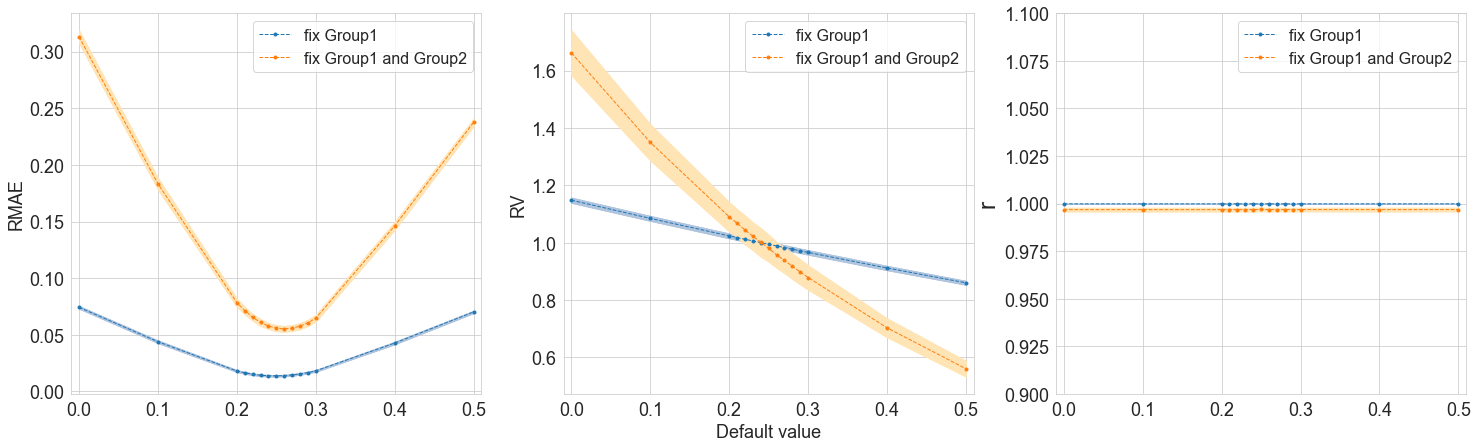

In [30]:
def plot_shadow(df, col_name, ax, ylabel, color, ylim=None, fs=None):
    df.loc[:, col_name].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax=ax)
    ax.fill_between(df.index, df[f'{col_name}_lower'], df[f'{col_name}_upper'], color=color)
    ax.fill_between(df.index, df[f'{col_name}_lower'], df[f'{col_name}_upper'], color=color)
    ax.set_xlim(-0.01, 0.51)
    if not (ylim==None):
        ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    if fs == None:
        ax.set_ylabel(ylabel, fontsize=18)
    else:
        ax.set_ylabel(ylabel, fontsize=24)    
    ax.legend(['fix Group1', 'fix Group1 and Group2'], fontsize=16)
# End plot_shadow()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
colors = ['lightsteelblue', 'moccasin']
k = 0
for df in [group1, group2]:
    color = colors[k]
    plot_shadow(df, 'mae', axes[0], 'RMAE', color)
    plot_shadow(df, 'var', axes[1], 'RV', color)
#     fig.suptitle('Morris (n=80)', fontsize=20)
    axes[1].set_xlabel('Default value',  fontsize=18)
    plot_shadow(df, 'ppmc', axes[2], 'r', color, [0.9, 1.1], 26)
    k += 1

plt.savefig(f'../output/adaptive_replicates/figure/fig8_evaluate_defaults.png', format='png', dpi=300)
